In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns


# Load and Preprocess Data 

In [4]:
# Load dataset
df = pd.read_csv('balanced_augmented_dataset.csv')

# Modify labels: 0 -> 1, others (1,2,3,4) -> 0
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)

# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['label']))
y = df['label'].values

# Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = rf.feature_importances_
feature_names = df.drop(columns=['label']).columns

# Select top k features
k = 7
top_features = [feature for feature, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:k]]

# Reduce dataset to selected features
X_selected = df[top_features]

# Compute correlation matrix
corr_matrix = X_selected.corr()

# Normalize selected features
X_selected = scaler.fit_transform(X_selected)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.view(-1)  # Make sure it's flat

print("Top selected features:", top_features)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(y_train)



Top selected features: ['has_native_code', 'num_providers', 'version_code', 'file_size_kb', 'num_files', 'total_methods', 'num_intents']
torch.Size([4200, 7]) torch.Size([1800, 7]) torch.Size([4200]) torch.Size([1800])
tensor([1., 1., 1.,  ..., 1., 0., 1.])


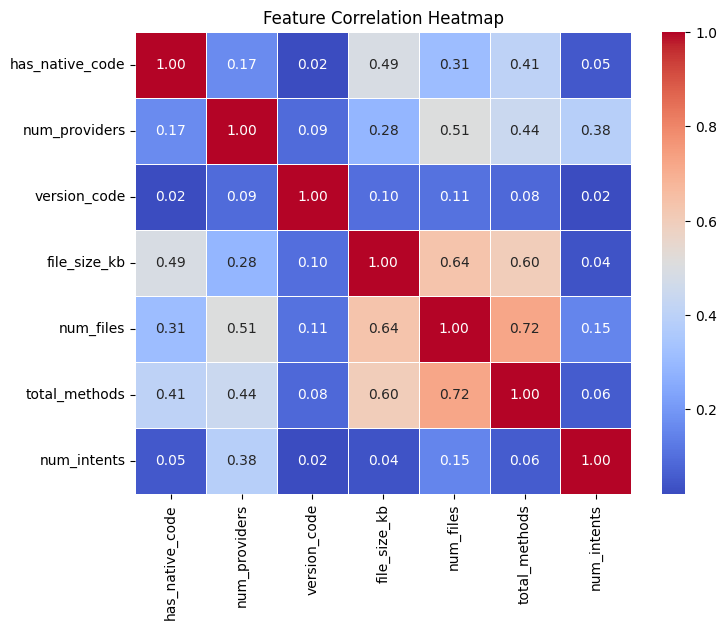

In [5]:
# Plot heatmap in a separate cell
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()



# ANFIS Model

In [19]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        
        # Fuzzy Membership Parameters (Gaussian functions) - Ensuring Stability
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))
        self.sigma = nn.Parameter(torch.randn(input_dim, num_rules).abs() + 1e-6)  # Avoiding zero sigma
        
        # Output Layer
        self.linear = nn.Linear(num_rules, 1)  # Single output for binary classification
    
    def forward(self, x):
        # Gaussian Membership Functions - Adding Stability
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        
        # Rule Activation (Product of Memberships)
        rule_activation = torch.prod(membership, dim=1)
        
        # Normalize Rule Activations - Prevent Division by Zero
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        rule_strengths = rule_activation / sum_activation
        
        # Weighted Rule Outputs
        output = self.linear(rule_strengths)
        
        return output.squeeze()  # Apply sigmoid for binary classification

# Initialize model
input_dim = X_train.shape[1]
num_rules = 5  # Number of fuzzy rules
model = ANFIS(input_dim, num_rules)


# training

In [21]:
class_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Training loop
num_epochs = 4000 # Increase training epochs for better convergence
for epoch in range(num_epochs):
    criterion = nn.BCEWithLogitsLoss()

    optimizer.zero_grad()
    outputs = model(X_train)
    outputs = torch.clamp(outputs, min=1e-7, max=1.0-1e-7)
    loss = criterion(outputs, y_train)  # Use adjusted loss function
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/4000], Loss: nan
Epoch [20/4000], Loss: nan
Epoch [30/4000], Loss: nan
Epoch [40/4000], Loss: nan
Epoch [50/4000], Loss: nan
Epoch [60/4000], Loss: nan
Epoch [70/4000], Loss: nan
Epoch [80/4000], Loss: nan
Epoch [90/4000], Loss: nan
Epoch [100/4000], Loss: nan
Epoch [110/4000], Loss: nan
Epoch [120/4000], Loss: nan
Epoch [130/4000], Loss: nan
Epoch [140/4000], Loss: nan
Epoch [150/4000], Loss: nan
Epoch [160/4000], Loss: nan
Epoch [170/4000], Loss: nan
Epoch [180/4000], Loss: nan
Epoch [190/4000], Loss: nan
Epoch [200/4000], Loss: nan
Epoch [210/4000], Loss: nan
Epoch [220/4000], Loss: nan
Epoch [230/4000], Loss: nan
Epoch [240/4000], Loss: nan
Epoch [250/4000], Loss: nan
Epoch [260/4000], Loss: nan
Epoch [270/4000], Loss: nan
Epoch [280/4000], Loss: nan
Epoch [290/4000], Loss: nan
Epoch [300/4000], Loss: nan
Epoch [310/4000], Loss: nan
Epoch [320/4000], Loss: nan
Epoch [330/4000], Loss: nan
Epoch [340/4000], Loss: nan
Epoch [350/4000], Loss: nan
Epoch [360/4000], Loss: nan
E

Test Loss: nan
Precision: 1.0000


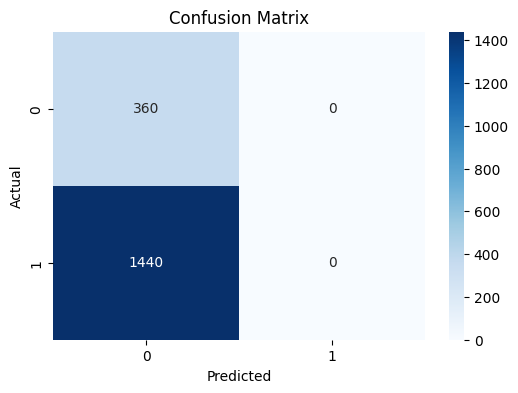

Confusion Matrix:
[[ 360    0]
 [1440    0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33       360
         1.0       1.00      0.00      0.00      1440

    accuracy                           0.20      1800
   macro avg       0.60      0.50      0.17      1800
weighted avg       0.84      0.20      0.07      1800



In [9]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions to binary labels
y_pred_class = (y_pred > 0.5).int().numpy()
y_test_numpy = y_test.numpy()

# Calculate precision
precision = precision_score(y_test_numpy, y_pred_class, average='binary', zero_division=1)
print(f'Precision: {precision:.4f}')

conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)
# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
# Generate confusion matrix

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class, zero_division=1))

# Testing

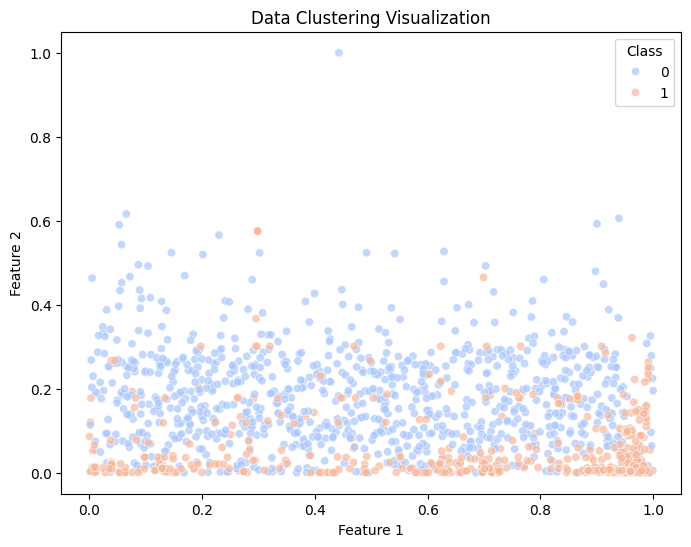

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Visualization')
plt.legend(title='Class')
plt.show()

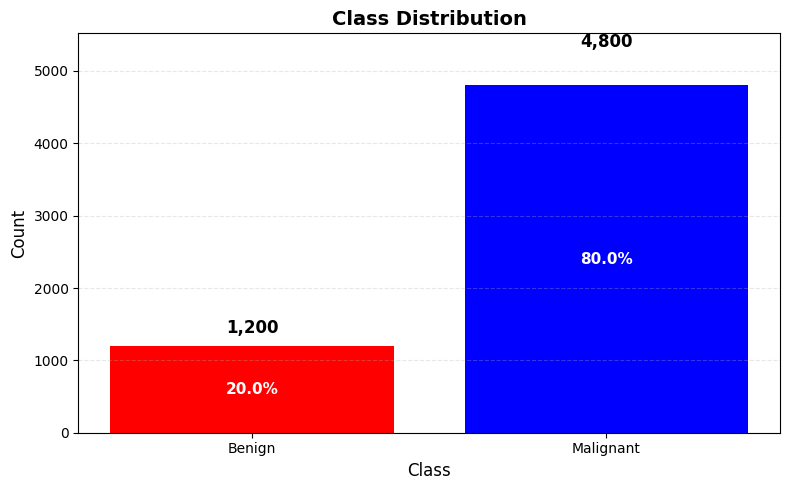


Class Distribution Summary:
Benign: 1,200 samples (20.0%)
Malignant: 4,800 samples (80.0%)
Total: 6,000 samples


In [22]:
plt.figure(figsize=(8, 5))
class_counts = pd.Series(y).value_counts()

# Create bar plot
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1*height,
             f'{int(height):,}',  # Format with comma for thousands
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Set labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)

# Ensure there's enough room for the labels
plt.ylim(0, max(class_counts.values) * 1.15)  # Add 15% padding at the top

# Add percentage labels inside bars
total = class_counts.sum()
for i, bar in enumerate(bars):
    percentage = (class_counts.values[i] / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%', 
             ha='center', va='center', fontsize=11, 
             color='white', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Print summary statistics
print("\nClass Distribution Summary:")
print(f"Benign: {class_counts.get(0, 0):,} samples ({class_counts.get(0, 0)/total*100:.1f}%)")
print(f"Malignant: {class_counts.get(1, 0):,} samples ({class_counts.get(1, 0)/total*100:.1f}%)")
print(f"Total: {total:,} samples")

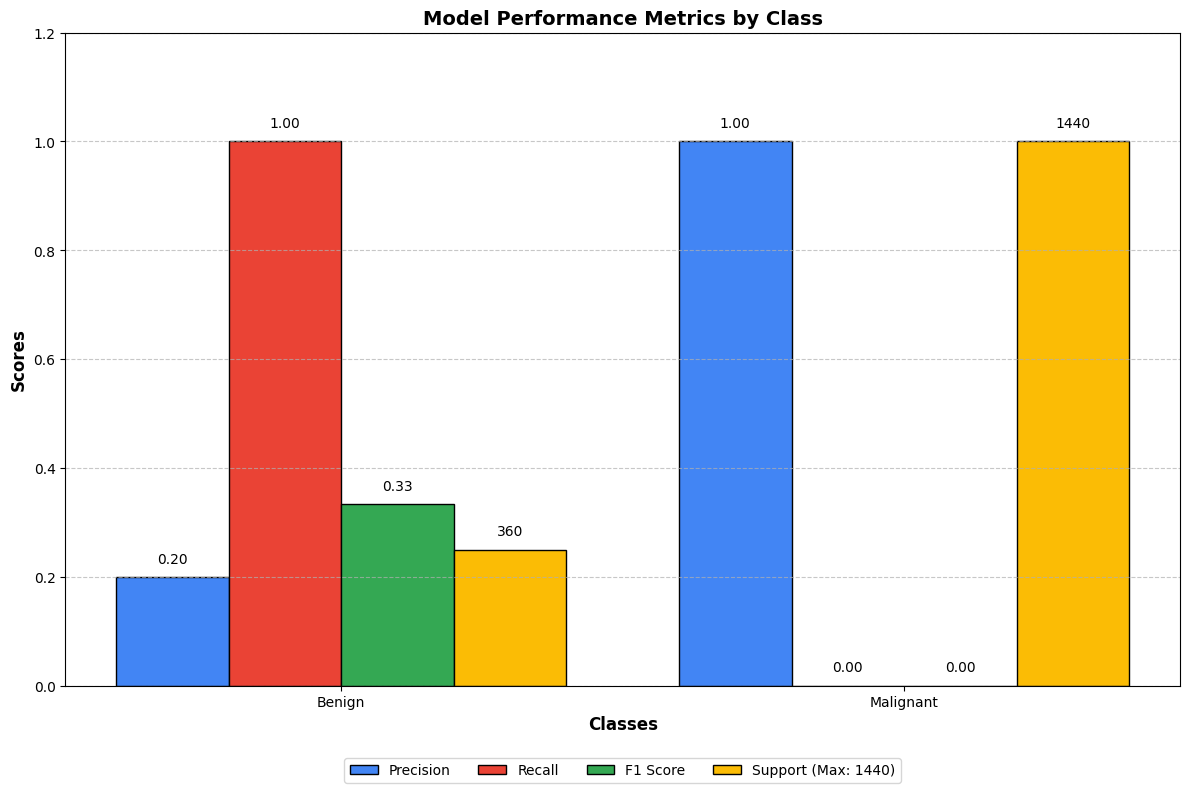

In [23]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Calculate precision, recall, f1-score and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test_numpy, y_pred_class, zero_division=1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bar and positions
barWidth = 0.2
r1 = np.arange(len(precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create bars
ax.bar(r1, precision, width=barWidth, label='Precision', color='#4285F4', edgecolor='black')
ax.bar(r2, recall, width=barWidth, label='Recall', color='#EA4335', edgecolor='black')
ax.bar(r3, f1, width=barWidth, label='F1 Score', color='#34A853', edgecolor='black')

# For support, we need to normalize it since it could be much larger
max_support = max(support)
normalized_support = [s/max_support for s in support]
ax.bar(r4, normalized_support, width=barWidth, label=f'Support (Max: {max_support})', color='#FBBC05', edgecolor='black')

# Add labels and title
plt.xlabel('Classes', fontweight='bold', fontsize=12)
plt.ylabel('Scores', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth*1.5 for r in range(len(precision))], ['Benign', 'Malignant'])
plt.title('Model Performance Metrics by Class', fontweight='bold', fontsize=14)

# Add value labels on top of bars
for i, r_list in enumerate([r1, r2, r3]):
    for j, r_val in enumerate(r_list):
        values = [precision, recall, f1]
        plt.text(r_val, values[i][j] + 0.02, f'{values[i][j]:.2f}', ha='center', va='bottom', fontsize=10)

# For support, add the actual values
for i, r_val in enumerate(r4):
    plt.text(r_val, normalized_support[i] + 0.02, f'{support[i]}', ha='center', va='bottom', fontsize=10)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Adjust layout and display
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.2)  # Set y-axis limit with some padding for text
plt.show()

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(model, X_test, y_test, figsize=(10, 8)):
    """
    Plots the ROC curve for the given model and calculates the AUC score.
    
    Args:
        model: The trained model with a predict method
        X_test: Test features
        y_test: True labels for test data
        figsize: Figure size as a tuple (width, height)
    """
    # Convert inputs to appropriate format if needed
    if isinstance(X_test, np.ndarray):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    
    if X_test.dim() == 1:
        X_test = X_test.unsqueeze(0)
        
    # Get probability predictions
    with torch.no_grad():
        y_pred_prob = model(X_test).numpy().flatten()
    
    # Get true labels as numpy array
    y_test_numpy = y_test.numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)
    
    # Calculate ROC curve points and AUC
    fpr, tpr, thresholds = roc_curve(y_test_numpy, y_pred_prob)
    auc_score = roc_auc_score(y_test_numpy, y_pred_prob)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, 
             label=f'ROC curve (AUC = {auc_score:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2,
             label='Random classifier (AUC = 0.5)')
    
    # Highlight key points
    best_threshold_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_idx]
    best_fpr, best_tpr = fpr[best_threshold_idx], tpr[best_threshold_idx]
    
    plt.scatter(best_fpr, best_tpr, color='red', s=100, zorder=3,
                label=f'Best threshold: {best_threshold:.3f}')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True, alpha=0.3)
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    
    # Add detailed info text box
    textstr = '\n'.join((
        f'AUC Score: {auc_score:.4f}',
        f'Best Threshold: {best_threshold:.4f}',
        f'At Best Threshold:',
        f'   TPR: {best_tpr:.4f}',
        f'   FPR: {best_fpr:.4f}',
        f'   Specificity: {1-best_fpr:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.65, 0.05, textstr, fontsize=9,
             verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics for further analysis if needed
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': auc_score,
        'best_threshold': best_threshold
    }

# Generate the ROC curve for your model
roc_results = plot_roc_curve(model, X_test, y_test)

# Print key metrics
print(f"ROC AUC Score: {roc_results['auc']:.4f}")
print(f"Best threshold: {roc_results['best_threshold']:.4f}")

ValueError: Input contains NaN.